# this code is used to study the rotation of the stellar halo

In [1]:
# this is used to analyse the rotation of the halo with K-giants
%matplotlib inline
import numpy as np
import astropy.io.fits as fits
import csv
import CoordinateConversion as CC
import matplotlib.pyplot as plt
import pandas as pd
import math
import PyAstronomy as PA
from PyAstronomy import pyasl as PAP
from scipy import signal
import scipy.optimize as SO
import galpy.util.bovy_coords as gub

In [2]:
path = "/Users/htian/Documents/GitHub/rothalo/"
dpath = path + "data/"
ppath = "/Users/htian/Documents/work/rothalo/plot/"
fn = "DR3_Kgiants_xxxdist.fits"

In [3]:
Dt = fits.open(dpath+fn)
Ds= Dt[1].data
raa = Ds['ra']
deca = Ds['dec']
la = Ds['glon']
ba = Ds['glat']
feha = Ds['feh']
rva = Ds['rv']
rvea = Ds['rv_err']
dista = Ds['d_xxx']
dist_erra = Ds['d_err_xxx']
Za = Ds['z_xxx']
Mga = Ds['Mg']
snrga = Ds['snrg']
snria = Ds['snri']
Mk50 = Ds['M_K50']
Dk50 = Ds['distK50_RJCE']
ind = (dista>0) & (dist_erra<20) & (Mga<10) & (dista<50) & \
(Mga>-10) & (snrga>10) & (snria>10)
ra,dec,l,b,feh,rv,rve,dist,dist_err,Z,Mg,snrg,snri = \
raa[ind],deca[ind],la[ind],ba[ind],feha[ind],rva[ind],rvea[ind],\
dista[ind],dist_erra[ind],Za[ind],Mga[ind],snrga[ind],snria[ind]
xyz = gub.lbd_to_XYZ(l,b,dist,degree=True)
x,y,z = xyz[:,0],xyz[:,1],xyz[:,2]
xg,yg,zg = 8-x,y,z
R = np.sqrt(xg**2+yg**2)
Vgsr = rv+9.58*np.cos(b*math.pi/180)*np.cos(l*math.pi/180)+ \
    (220+10.52)*np.cos(b*math.pi/180)*np.sin(l*math.pi/180)+ \
    7.01*np.sin(b*math.pi/180)
DD = np.sqrt(R**2+Z**2)
lnnu = np.zeros_like(R)+1

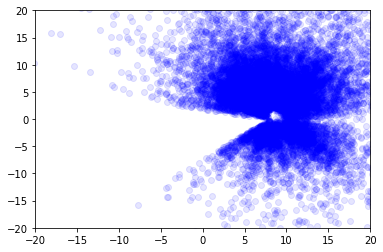

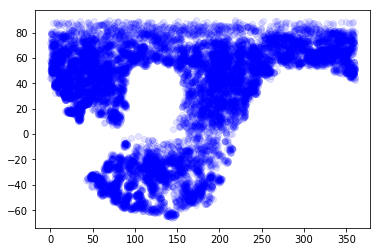

In [26]:
indt = np.abs(z)>5
plt.plot(8-x,z,'bo',alpha=0.1)
plt.axis([-20,20,-20,20])
plt.show()
plt.plot(l,b,'bo',alpha=0.1)
plt.show()
# plt.hist(DD[indt])

In [5]:
# # read the data--------------------------
# data_halo = np.loadtxt(dpath+fn_halo,skiprows=1)
# # obsid ra dec l b teff logg feh rv Mgb MK MKerr_low MKerr_up AK K dist disterr_low disterr_up Z R r_gc lnnu
# ind = (data_halo[:,21]>-10000000) #& (data_halo[:,18]>2) & (data_halo[:,18]<5) & (data_halo[:,19]>6) & (data_halo[:,19]<8)
# ra = data_halo[ind,1]
# dec = data_halo[ind,2]
# l = data_halo[ind,3]
# b = data_halo[ind,4]
# feh = data_halo[ind,7]
# rv = data_halo[ind,8]
# dist = data_halo[ind,15]
# Z = data_halo[ind,18]
# R = data_halo[ind,19]
# r_gc = data_halo[ind,20]
# lnnu = data_halo[ind,21]
# DD = np.sqrt(R**2+Z**2)
# Vgsr = rv+9.58*np.cos(b*math.pi/180)*np.cos(l*math.pi/180)+ \
#     (220+10.52)*np.cos(b*math.pi/180)*np.sin(l*math.pi/180)+ \
#     7.01*np.sin(b*math.pi/180)
# print(len(Z))

In [6]:
# plt.plot(np.sqrt(R**2+Z**2),dist,'k.')
# plt.show()
# plt.hist(feh,bins=100)

In [7]:
# plt.hist(dist,bins=20)

In [8]:
# plt.hist(data_halo[:,7],bins=20)
# print(len(data_halo[:,21]),len(ra))
# print(np.min(data_halo[:,21]))

In [9]:
# calculate the spherical coordinates centered at the galactic center
# aitoff projection
X_sun = 8.0
Xs,Ys,Zs = CC.sph2xyz(90-b,l,r=dist,Degree=True)
rcc,thetacc,phicc = CC.xyz2sph(X_sun-Xs,Ys,Zs,Degree=True)
Lgc = phicc
Bgc = 90-thetacc
rve = 10

In [10]:
# this is used to smooth the distribution
Ar = 2.5
cosAr = np.cos(Ar*math.pi/180)
ns = len(l)
M_vg = np.zeros(ns)
M_nu = np.zeros(ns)
Disp_nu = np.zeros(ns)
Disp_vg = np.zeros(ns)
M_rv = np.zeros(ns)
for i in range(0,ns):
    cosx = ((X_sun-Xs)*(X_sun-Xs[i])+Ys*Ys[i]+Zs*Zs[i])/\
    np.sqrt((X_sun-Xs[i])**2+Ys[i]**2+Zs[i]**2)/\
    np.sqrt((X_sun-Xs)**2+Ys**2+Zs**2)
    indc = cosx>cosAr
    if len(Vgsr[indc])>0:
        M_vg[i] = np.mean(Vgsr[indc])
        M_nu[i] = np.log(np.mean(math.e**(lnnu[indc])))
        Disp_vg[i] = np.std(Vgsr[indc])
        Disp_nu[i] = np.std(math.e**(lnnu[indc]))
        
#     cosxs = ((Xs)*(Xs[i])+Ys*Ys[i]+Zs*Zs[i])/\
#             np.sqrt((Xs[i])**2+Ys[i]**2+Zs[i]**2)/\
#             np.sqrt((Xs)**2+Ys**2+Zs**2)
#     indcs = cosxs>cosAr
    M_rv[i] = np.mean(rv[indc])

In [11]:
# THIS IS USED TO DO AITOFF CONVERSION
Xa, Ya = PAP.aitoff(Lgc, Bgc)
Xas,Yas = PAP.aitoff(l,b)

In [12]:
# convert lb to aitoff projection
nl = 2000
nb = 1000
bba = np.linspace(-90,90,nb+1)
lla = np.linspace(-180,180,nl+1)
bla = np.zeros(nl)
lba = np.zeros(nb)
b0,b30,b60,b130,b160 = 0,30,60,-30,-60
l0,l60,l120,l180,l060,l0120,l0180 = 0,60,120,180,-60,-120,-180
Xab0,Yab0 = PAP.aitoff(lla[:nl],bla+b0)
Xab30,Yab30 = PAP.aitoff(lla[:nl],bla+b30)
Xab60,Yab60 = PAP.aitoff(lla[:nl],bla+b60)
Xab130,Yab130 = PAP.aitoff(lla[:nl],bla+b130)
Xab160,Yab160 = PAP.aitoff(lla[:nl],bla+b160)

Xal0,Yal0 = PAP.aitoff(lba+l0,bba[:nb])
Xal60,Yal60 = PAP.aitoff(lba+l60,bba[:nb])
Xal120,Yal120 = PAP.aitoff(lba+l120,bba[:nb])
Xal180,Yal180 = PAP.aitoff(lba+l180,bba[:nb])
Xal060,Yal060 = PAP.aitoff(lba+l060,bba[:nb])
Xal0120,Yal0120 = PAP.aitoff(lba+l0120,bba[:nb])
Xal0180,Yal0180 = PAP.aitoff(lba+l0180,bba[:nb])


# plot density and Vgsr

In [13]:
def Gaussian2(x,a1,a2,m1,m2,s1,s2):
    return a1*np.exp(-((x-m1)/s1)**2)+a2*np.exp(-((x-m2)/s2)**2)
def Gaussian1(x,a,m,s):
    return a*np.exp(-((x-m)/s)**2)

In [14]:
lw=0.2
thk = 3
# bbins = np.array([-50,-40,-30,-20,-10,0,10,20,30,40,50,60,75,90]) #13 bins
# sym = ['b--','c--','r--','y--','m--','m-','y-','r-','c-','b-','k-','k--','k-.']
# bbins = np.linspace(-50,90,8)
# sym = ['b--','c--','k-','r-','c-','g-','m-']
bbins = np.linspace(0,90,7)
sym = ['m-','y-','r-','c-','b-','k-','r-','g-']
lsym = ['m--','y--','r--','c--','b--','k--','r--','g--']

# plot average density and Vgsr

# plot radial velocity

# plot Vgsr vs l

In [15]:
def sinfit(x,a,b,c,d):
    return a*np.sin(b*x+c)+d
thk = 2
print(np.min(np.abs(Bgc)))

0.00481073249296


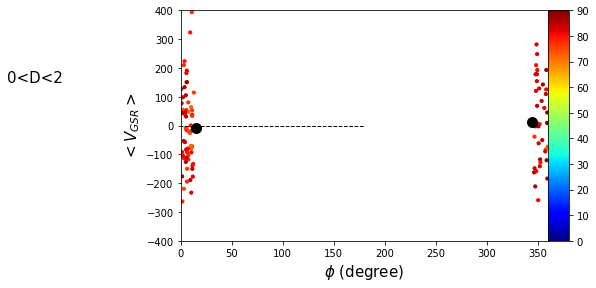

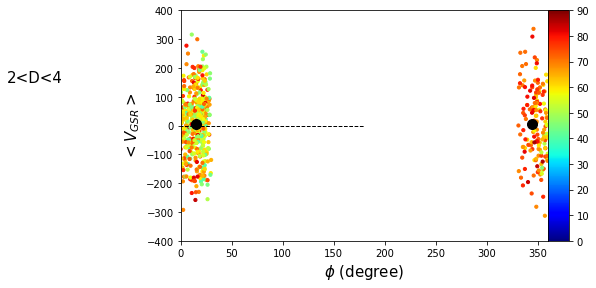

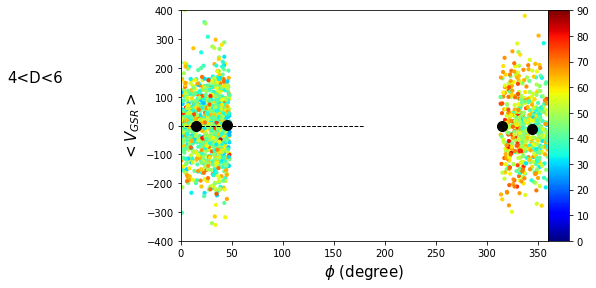

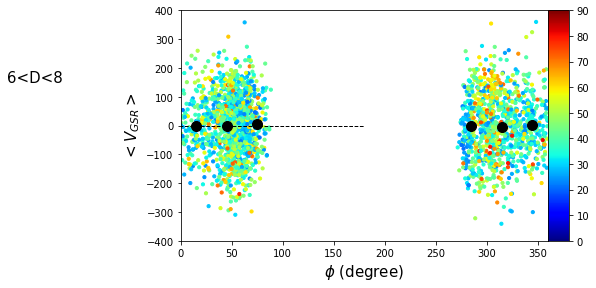

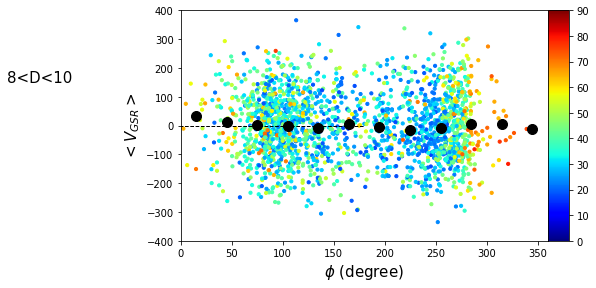

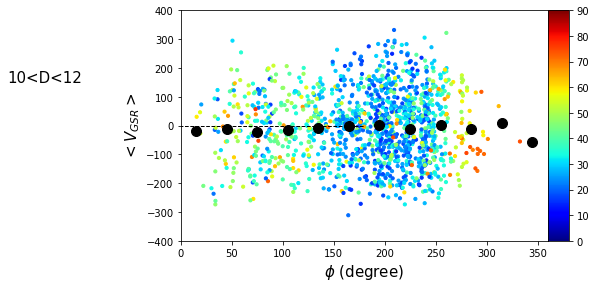

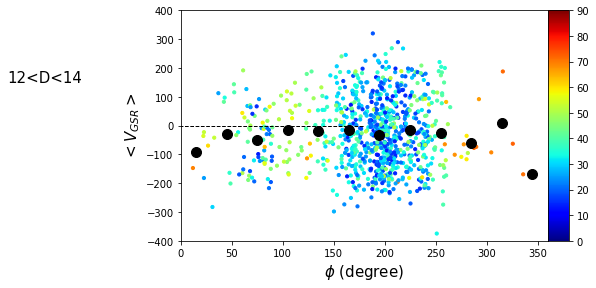

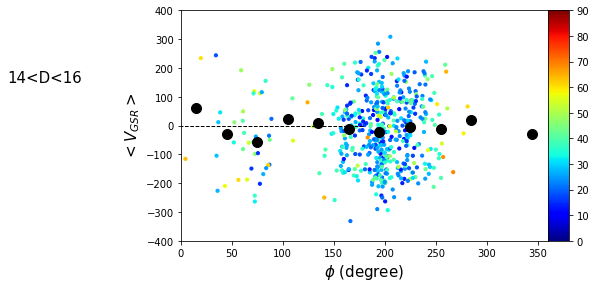

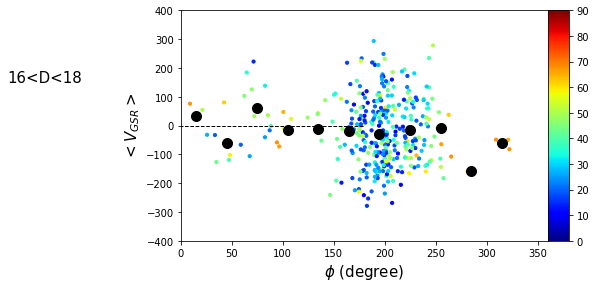

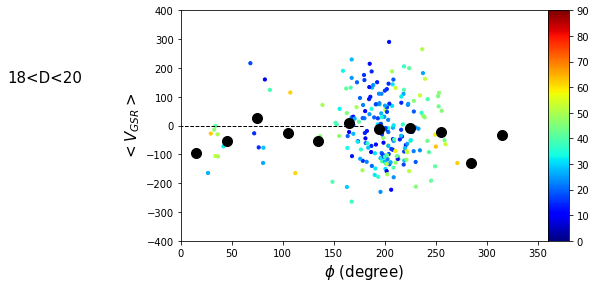

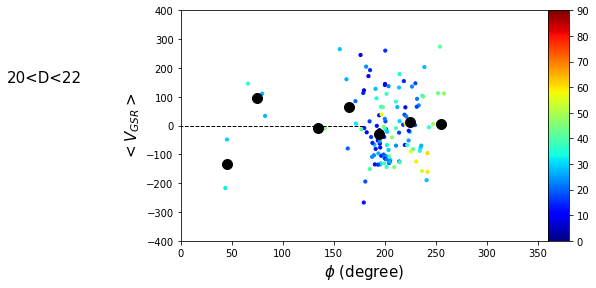

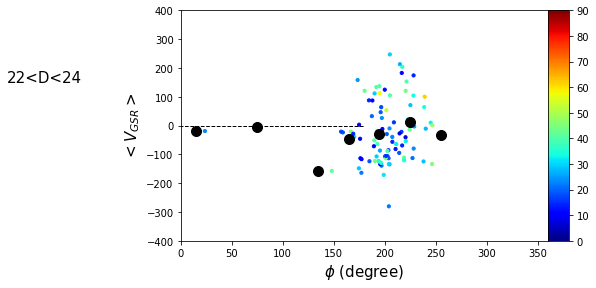

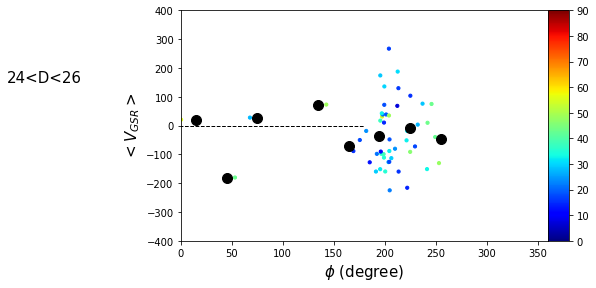

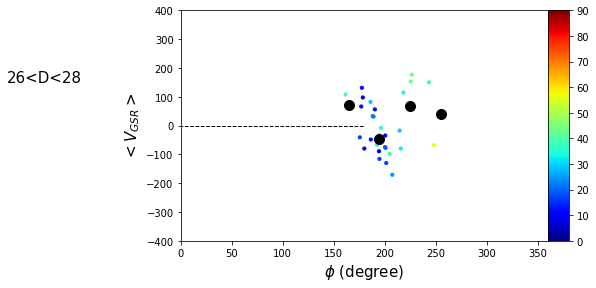

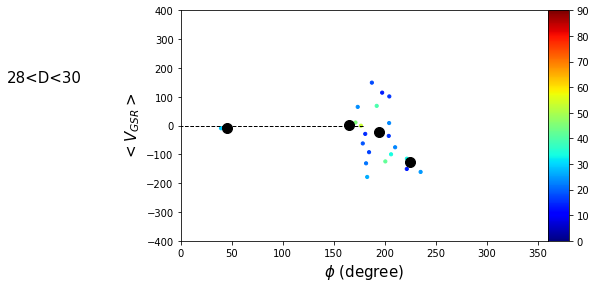

In [16]:
for i in range(0,15):
    dmin = 0+thk*i
    dmax = dmin+thk
    indb = (R>dmin) & (R<dmax) & (Z>3) #& (np.abs(Z)>3) # & (b>30)
    fig = plt.figure(figsize=(6,4))
    ax0 = fig.add_axes([0.05,0.1,0.85,0.8])
    ax0.plot([-180,180],[0,0],'k--',linewidth=1)
    ca = ax0.scatter(l[indb],Vgsr[indb],s=10,c=Bgc[indb],vmin=0,vmax=90,cmap='jet')
#     ca = ax0.scatter(Lgc[indb],Vgsr[indb],s=10,c=feh[indb],vmin=-2.5,vmax=-1,cmap='jet')

    lss = l[indb]
    Vss = Vgsr[indb]
    Lbin = 30
    L_n = int(360/Lbin)
    m_l = np.linspace(0,360,L_n+1)+Lbin/2#-180
    m_v = np.zeros(L_n)-90000
    S_v = np.zeros(L_n)-90000
    n_v = np.zeros(L_n)
    Lmm = np.linspace(0,360,L_n+1)
    for j in range(0,int(L_n)):
        indl = (lss>Lmm[j]) & (lss<Lmm[j+1])
#         indl = (lss>Lmm[j]-Lbin/2) & (lss<Lmm[j+1]+Lbin/2)
        n_v[j] = len(lss[indl])
        if n_v[j]>0:
            m_v[j] = np.mean(Vss[indl])
            S_v[j] = np.std(Vss[indl])
#     ca = ax0.scatter(l[indb],M_vg[indb],s=10,c=b[indb],vmin=30,vmax=90,cmap='jet')
#     ca = ax0.scatter(Lgc[indb],M_vg[indb],s=10,c=Bgc[indb],vmin=30,vmax=90,cmap='jet')
    inds = n_v>0
#     inds[7:9] = False
#     inds[8] = False
#     ax0.errorbar(m_l[:L_n],m_v,xerr=15,yerr=S_v*0+rve,fmt='ko')
    ax0.plot(m_l[:L_n][inds],m_v[inds],'ko',markersize=10)
    if len(n_v[inds])>10:
        popt,pcov = SO.curve_fit(sinfit,(Lmm[:len(Lmm)-1][inds]+Lbin/2)*math.pi/180,m_v[inds],\
                                 bounds=([0,0.5,-math.pi/2,-100],[200,1.5,math.pi/2,100]))
#         plt.plot(Lmm[:len(Lmm)-1][inds]+Lbin/2,m_v[inds],'b<')
        xl = np.linspace(-1*math.pi,math.pi,10000)
#         ax0.plot(xl*180/math.pi,sinfit(xl,*popt),'r--')
#         print(dmin,*popt,'----',np.sqrt(np.diag(pcov)))
#     print(dmin,m_v)
    ax0.set_xlabel('$\\phi$ (degree)',fontsize=15)
    ax0.set_ylabel('$<V_{GSR}>$',fontsize=15)
    ax1 = fig.add_axes([0.9,0.1,0.05,0.8])
    ax0.set_xlim((0,360))
    ax0.set_ylim((-400,400))
    plt.colorbar(ca,ax1)
    ax0.text(-170,150,"{dmin}<D<{dmax}".format(**locals()),fontsize=15)
    plt.savefig(ppath+"l_Vg_D_{dmin}_{dmax}.eps".format(**locals()))
#     plt.close(all)

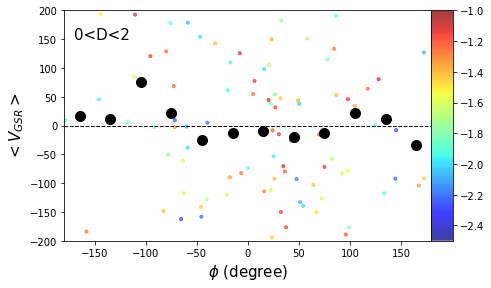

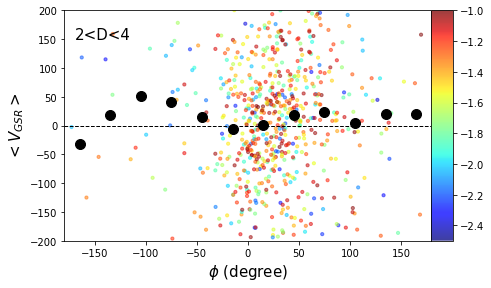

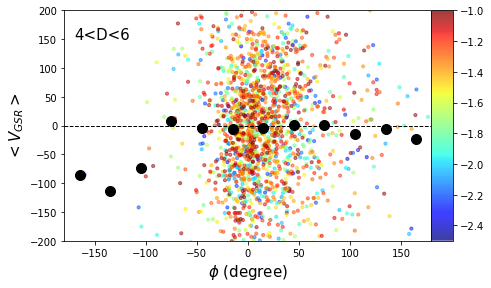

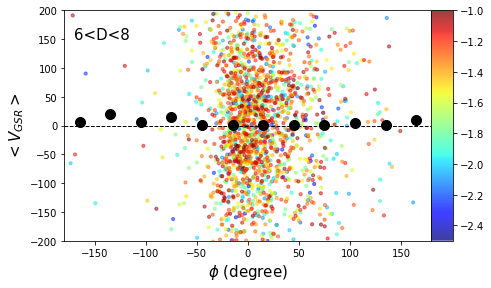

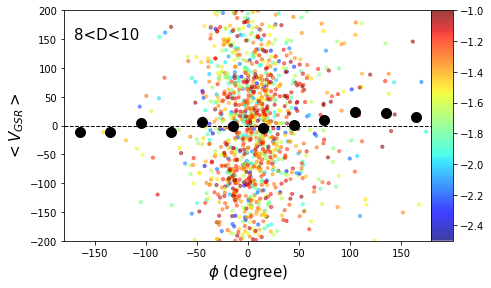

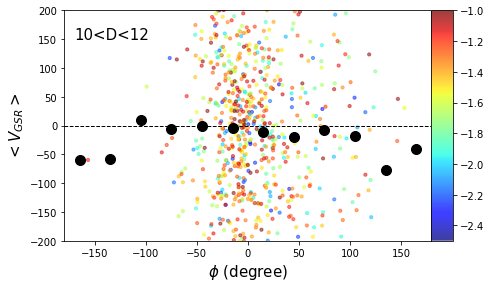

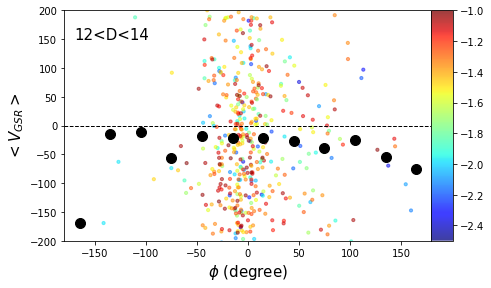

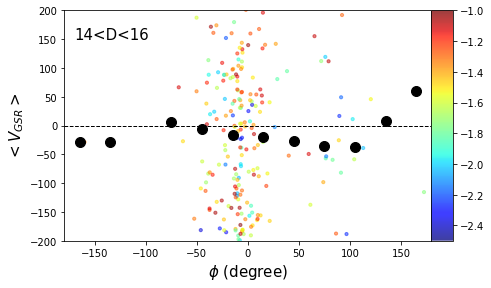

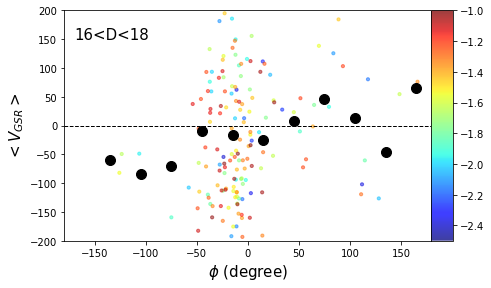

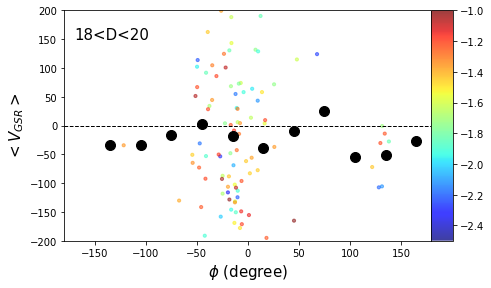

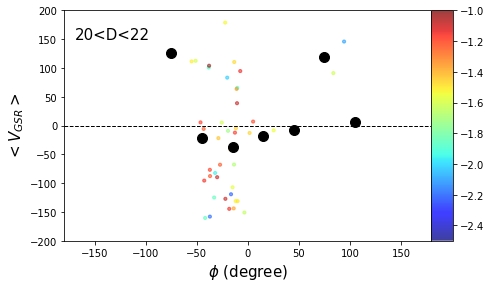

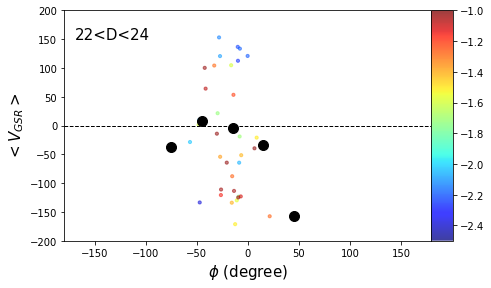

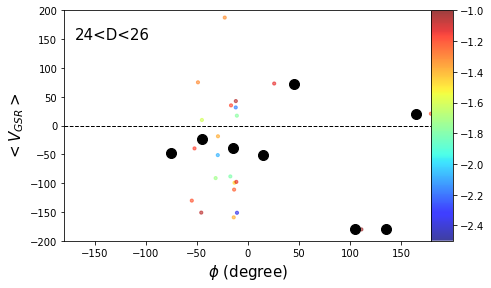

In [17]:
for i in range(0,13):
    dmin = 0+thk*i
    dmax = dmin+thk
    indb = (R>dmin) & (R<dmax) & (Bgc>30) & (feh<1.5)
    fig = plt.figure(figsize=(6,4))
    ax0 = fig.add_axes([0.05,0.1,0.85,0.8])
    ax0.plot([-180,180],[0,0],'k--',linewidth=1)
#     ca = ax0.scatter(Lgc[indb],Vgsr[indb],s=10,c=Bgc[indb],vmin=30,vmax=90,cmap='jet')
    ca = ax0.scatter(Lgc[indb],Vgsr[indb],s=10,c=feh[indb],vmin=-2.5,vmax=-1.,cmap='jet',alpha=0.5)
    Lbin=30
    L_n = int(360/Lbin)
    m_l = np.linspace(0,360,L_n+1)+Lbin/2-180
    m_v = np.zeros(L_n)-90000
    S_v = np.zeros(L_n)-90000
    n_v = np.zeros(L_n)
    lss = Lgc[indb]
    Vss = Vgsr[indb]
    Lmm = np.linspace(-180,180,L_n+1)
    for j in range(0,L_n):
        indl = (lss>Lmm[j]-Lbin/2) & (lss<Lmm[j+1]+Lbin/2)
        n_v[j] = len(lss[indl])
        if n_v[j]>0:
            m_v[j] = np.mean(Vss[indl])
            S_v[j] = np.std(Vss[indl])
#     ca = ax0.scatter(l[indb],M_vg[indb],s=10,c=b[indb],vmin=30,vmax=90,cmap='jet')
#     ca = ax0.scatter(Lgc[indb],M_vg[indb],s=10,c=Bgc[indb],vmin=30,vmax=90,cmap='jet')
#     ax0.errorbar(m_l[:L_n],m_v,xerr=Lbin/2,yerr=S_v*0+rve,fmt='ko',markersize=15)
    inds = n_v>0
    ax0.plot(m_l[:L_n][inds],m_v[inds],'ko',markersize=10)
    
#     popt,pcov = SO.curve_fit(sinfit,m_l[3:10]*math.pi/180,m_v[3:10],bounds=([-100,0.5,-0.5*math.pi,-50],\
#         [100,2,0.5*math.pi,50]))
#     print(dmin,dmax,popt)
    xxx = np.linspace(-180,180,1000)
#     plt.plot(xxx,sinfit(xxx*math.pi/180,*popt),'k--',linewidth=3)
    
    ax0.set_xlabel('$\\phi$ (degree)',fontsize=15)
    ax0.set_ylabel('$<V_{GSR}>$',fontsize=15)
    ax1 = fig.add_axes([0.9,0.1,0.05,0.8])
    ax0.set_xlim((-180,180))
    ax0.set_ylim((-200,200))
    plt.colorbar(ca,ax1)
    ax0.text(-170,150,"{dmin}<D<{dmax}".format(**locals()),fontsize=15)
    plt.savefig(ppath+"l_Vg_D_{dmin}_{dmax}.eps".format(**locals()))

In [18]:
# if there is structure at phi=50

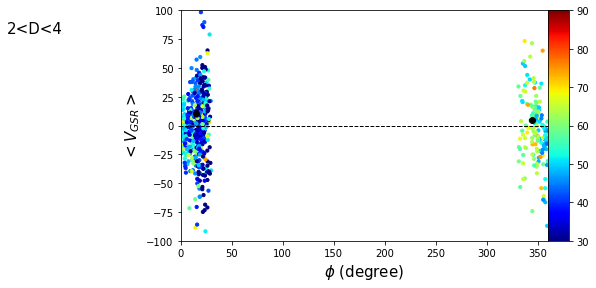

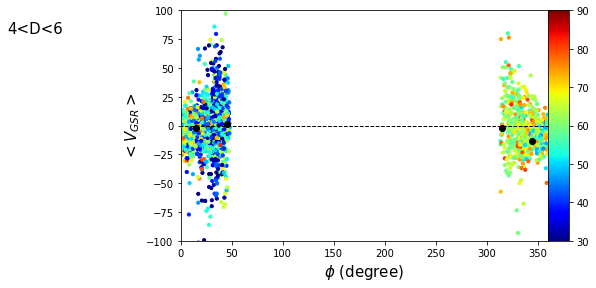

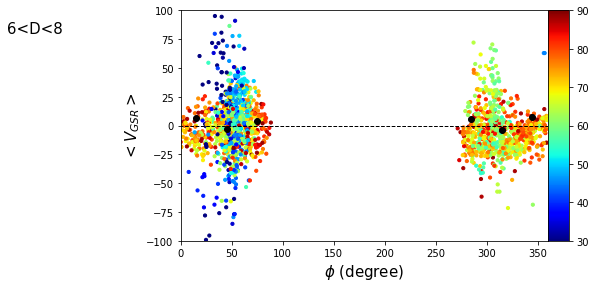

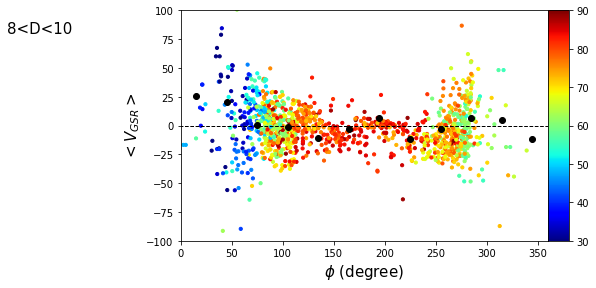

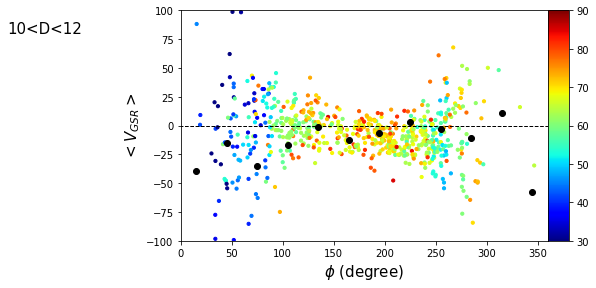

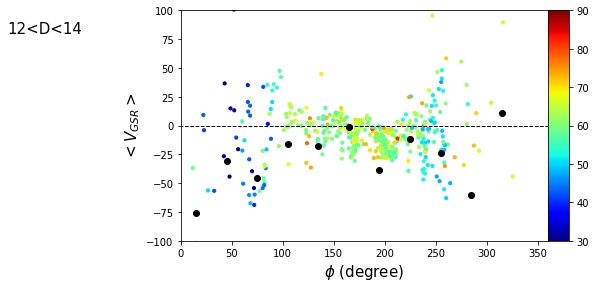

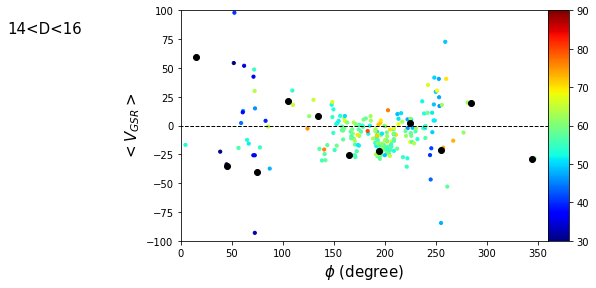

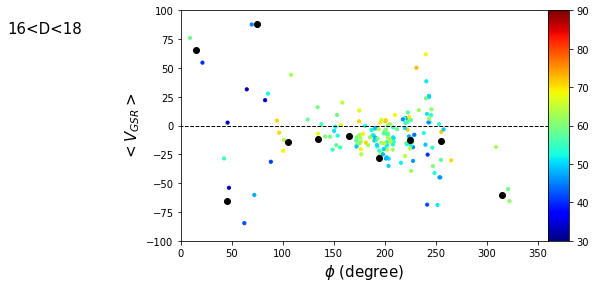

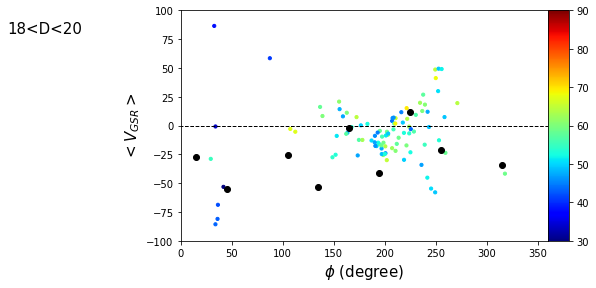

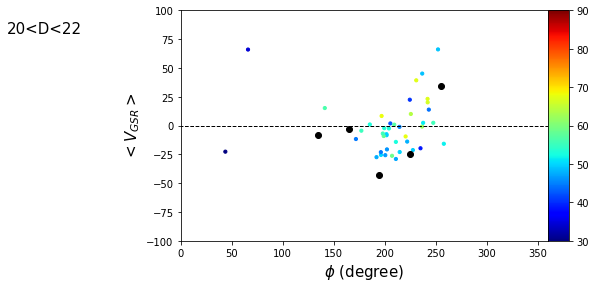

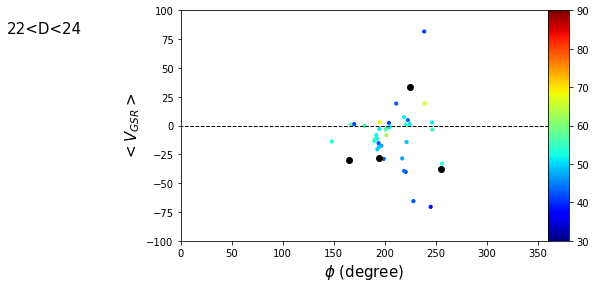

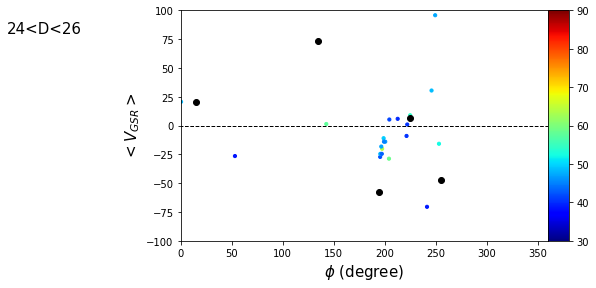

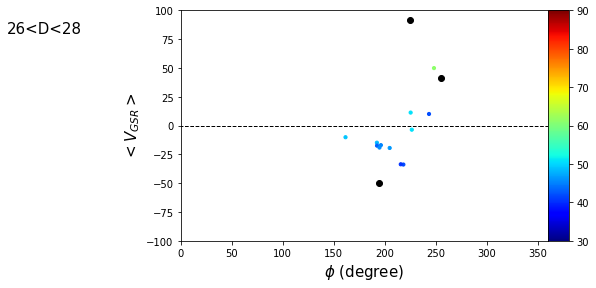

In [19]:
for i in range(0,13):
    dmin = 2+thk*i
    dmax = dmin+thk
    indb = (R>dmin) & (R<dmax) & (Bgc>30)
    fig = plt.figure(figsize=(6,4))
    ax0 = fig.add_axes([0.05,0.1,0.85,0.8])
    ax0.plot([-360,360],[0,0],'k--',linewidth=1)
#     ca = ax0.scatter(Lgc[indb],Vgsr[indb],s=10,c=Bgc[indb],vmin=30,vmax=90,cmap='jet')
#     ca = ax0.scatter(Lgc[indb],Vgsr[indb],s=10,c=feh[indb],vmin=-2.5,vmax=-1,cmap='jet')
    m_l = np.linspace(0,360,13)+15#-180
    m_v = np.zeros(12)-90000
    S_v = np.zeros(12)-90000
    lss = l[indb]
#     lss = Lgc[indb]
    Vss = Vgsr[indb]
    for j in range(0,12):
        indl = (lss>j*30) & (lss<j*30+30)
#         indl = (lss>j*30-180) & (lss<j*30+30-180)
        if len(lss[indl])>0:
            m_v[j] = np.mean(Vss[indl])
            S_v[j] = np.std(Vss[indl])
    ca = ax0.scatter(l[indb],M_vg[indb],s=10,c=b[indb],vmin=30,vmax=90,cmap='jet')
#     ca = ax0.scatter(Lgc[indb],M_vg[indb],s=10,c=Bgc[indb],vmin=30,vmax=90,cmap='jet')
    ax0.plot(m_l[:12],m_v,'ko')
#     ax0.errorbar(m_l[:12],m_v,xerr=15,yerr=S_v,fmt='ko')
    ax0.set_xlabel('$\\phi$ (degree)',fontsize=15)
    ax0.set_ylabel('$<V_{GSR}>$',fontsize=15)
    ax1 = fig.add_axes([0.9,0.1,0.05,0.8])
    ax0.set_xlim((0,360))
    ax0.set_ylim((-100,100))
    plt.colorbar(ca,ax1)
    ax0.text(-170,80,"{dmin}<D<{dmax}".format(**locals()),fontsize=15)
    plt.savefig(ppath+"l_Vg_D_{dmin}_{dmax}.eps".format(**locals()))

In [20]:
# feh1 = feh[(feh>-2.5) & (feh<-2)]
# feh2 = feh[(feh>-2) & (feh<-1.5)]
# feh3 = feh[(feh>-1.5) & (feh<-1)]
# for i in range(0,13):
#     dmin = 2+thk*i
#     dmax = dmin+thk
#     indb = (R>dmin) & (R<dmax) & (Bgc>30)
#     indb1 = (R>dmin) & (R<dmax) & (Bgc>30) & (feh>-2.5) & (feh<-2)
#     indb2 = (R>dmin) & (R<dmax) & (Bgc>30) & (feh>-2) & (feh<-1.5)
#     indb3 = (R>dmin) & (R<dmax) & (Bgc>30) & (feh>-1.5) & (feh<-1)
    
#     fig = plt.figure(figsize=(6,4))
#     ax0 = fig.add_axes([0.05,0.1,0.85,0.8])
#     ax0.plot([-180,180],[0,0],'k--',linewidth=1)
# #     ca = ax0.scatter(Lgc[indb],Vgsr[indb],s=10,c=Bgc[indb],vmin=30,vmax=90,cmap='jet')
#     ca = ax0.scatter(Lgc[indb],Vgsr[indb],s=10,c=feh[indb],vmin=-2.5,vmax=-1,cmap='jet')
#     m_l = np.linspace(0,360,13)+15-180
#     m_v = np.zeros(12)-90000
#     S_v = np.zeros(12)-90000
#     m_v1 = np.zeros(12)-90000
#     m_v2 = np.zeros(12)-90000
#     m_v3 = np.zeros(12)-90000
#     lss = Lgc[indb]
#     Vss = Vgsr[indb]
#     lss1 = Lgc[indb1]
#     Vss1 = Vgsr[indb1]
#     lss2 = Lgc[indb2]
#     Vss2 = Vgsr[indb2]
#     lss3 = Lgc[indb3]
#     Vss3 = Vgsr[indb3]
    
#     for j in range(0,12):
#         indl = (lss>j*30-180) & (lss<j*30+30-180)
#         indl1 = (lss1>j*30-180) & (lss1<j*30+30-180)
#         indl2 = (lss2>j*30-180) & (lss2<j*30+30-180)
#         indl3 = (lss3>j*30-180) & (lss3<j*30+30-180)
#         m_v[j] = np.mean(Vss[indl])
#         m_v1[j] = np.mean(Vss1[indl1])
#         m_v2[j] = np.mean(Vss2[indl2])
#         m_v3[j] = np.mean(Vss3[indl3])
#         S_v[j] = np.std(Vss[indl])
# #     ca = ax0.scatter(l[indb],M_vg[indb],s=10,c=b[indb],vmin=30,vmax=90,cmap='jet')
# #     ca = ax0.scatter(Lgc[indb],M_vg[indb],s=10,c=Bgc[indb],vmin=30,vmax=90,cmap='jet')
# #     ax0.errorbar(m_l[:12],m_v,xerr=15,yerr=S_v,fmt='ko')
#     ax0.plot(m_l[:12],m_v,'ko--',markersize=10,label='total halo stars')
#     ax0.plot(m_l[:12],m_v1,'r<--',markersize=10,label='-2.5<FeH<2.0')
#     ax0.plot(m_l[:12],m_v2,'gs--',markersize=10,label='-2.0<FeH<1.5')
#     ax0.plot(m_l[:12],m_v3,'bp--',markersize=10,label='-1.5<FeH<1.0')
#     ax0.set_xlabel('$\\phi$ (degree)',fontsize=15)
#     ax0.set_ylabel('$<V_{GSR}>$',fontsize=15)
#     ax1 = fig.add_axes([0.9,0.1,0.05,0.8])
#     ax0.set_xlim((-180,180))
#     ax0.set_ylim((-400,400))
#     plt.colorbar(ca,ax1)
#     ax0.legend(loc=2)
#     ax0.text(100,300,"{dmin}<R<{dmax}".format(**locals()),fontsize=15)
#     plt.savefig(ppath+"l_Vg_D_{dmin}_{dmax}.eps".format(**locals()))

In [21]:
def fit_sin(x,ca,cb,cc,cd):
    return ca*np.sin(cb*x+cc)+cd

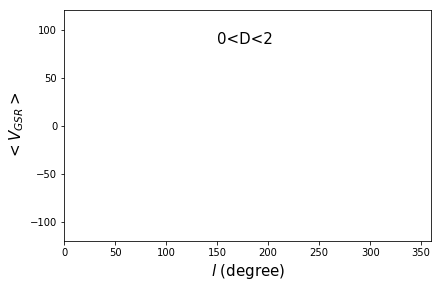

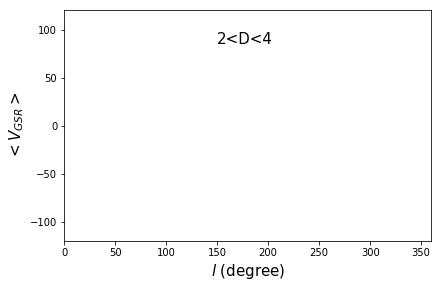

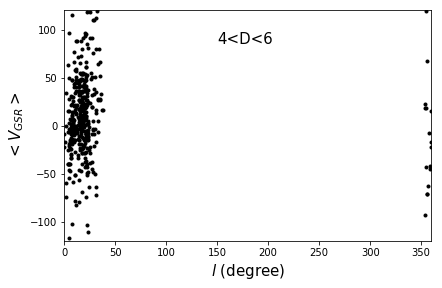

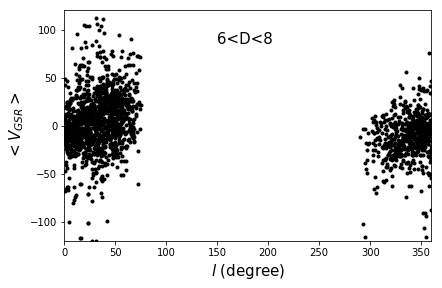

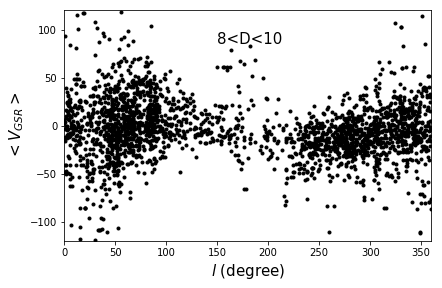

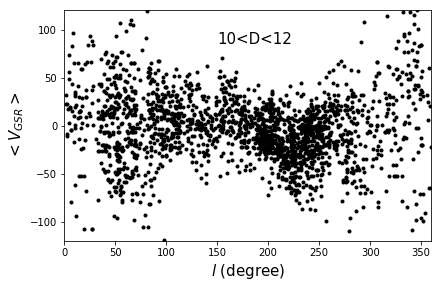

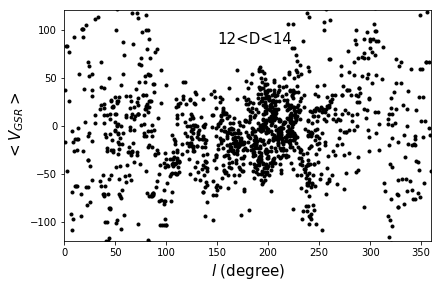

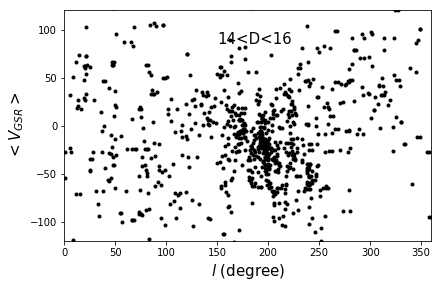

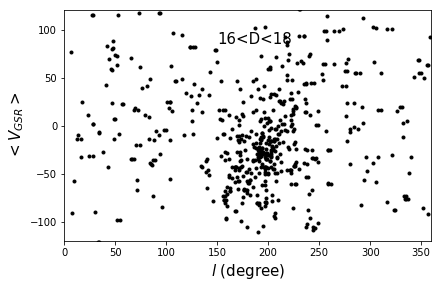

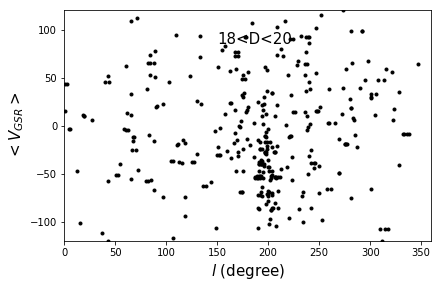

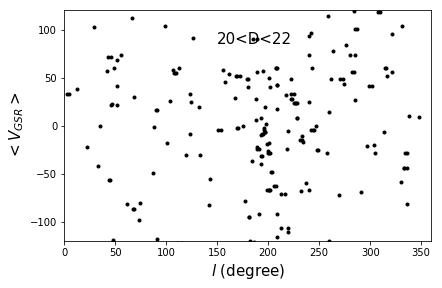

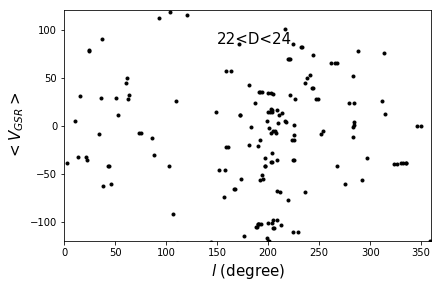

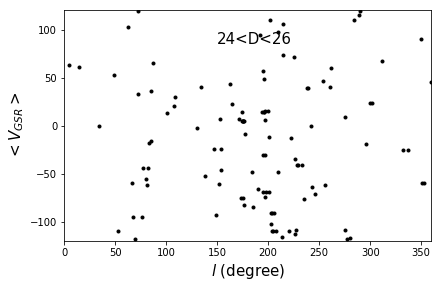

In [22]:
for i in range(0,13):
    dmin = 0+thk*i
    dmax = dmin+thk
    indb = (DD>dmin) & (DD<dmax) & (b>30)
    indf1 = (DD>dmin) & (DD<dmax) & (b>50)
    indf2 = (DD>dmin) & (DD<dmax) & (b<50) & (b>30)
#     print('-----------------  D_{dmin}_{dmax}  '.format(**locals()))
#     print(popt1)
#     print(popt2)
    b0 = b[indb]
    Xs0 = Xs[indb]
    Ys0 = Ys[indb]
    Zs0 = Zs[indb]
    nsd = len(DD[indb])
    Vgsr0 = Vgsr[indb]
    M_vg0 = lnnu[indb]
#     Disp_vg0 = np.zeros(nsd)
#     Disp_nu0 = np.zeros(nsd)
    for j in range(0,nsd):
        cosx0 = ((X_sun-Xs0)*(X_sun-Xs0[j])+Ys0*Ys0[j]+ \
        Zs0*Zs0[j])/np.sqrt((X_sun-Xs0[j])**2+Ys0[j]**2+Zs0[j]**2)/\
        np.sqrt((X_sun-Xs0)**2+Ys0**2+Zs0**2)
        indc = cosx0>cosAr
        if len(Vgsr0[indc])>0:
            M_vg0[j] = np.mean(Vgsr0[indc])
#             Disp_nu0[j] = np.std(math.e**(lnnu0[indc]))


#     popt1,pcov1 = SO.curve_fit(fit_sin,l[indf1]*math.pi/180,M_vg[indf1],bounds=([0,0.5,0,-100],\
#         [1000,1.5,360,100]))
#     popt2,pcov2 = SO.curve_fit(fit_sin,l[indf2]*math.pi/180,M_vg[indf2],bounds=([0,0.8,0,-100],\
#         [1000,2,360,100]))
    indbf1 = (b0>50)
    indbf2 = (b0>30) & (b0<50)
    xxx = np.linspace(0,360*math.pi/180,1000)
    fig = plt.figure(figsize=(6,4))
    ax0 = fig.add_axes([0.05,0.1,0.85,0.8])
    ax0.plot(l[indb],M_vg0,'k.')


#     ax0.plot(l[indf1],M_vg0[indbf1],'k.')
#     ax0.plot(l[indf2],M_vg0[indbf2],'r+')
#     ax0.plot(l[indf1],M_vg[indf1],'k.')
#     ax0.plot(l[indf2],M_vg[indf2],'r+')
#     ca = ax0.scatter(l[indb],M_vg[indb],s=10,c=b[indb],vmin=30,vmax=90,cmap='jet')
#     ca = ax0.scatter(Lgc[indb],M_vg[indb],s=10,c=Bgc[indb],vmin=30,vmax=90,cmap='jet')
#     ax0.plot(xxx*180/math.pi,fit_sin(xxx,*popt1),'g-',linewidth=3)
#     ax0.plot(xxx*180/math.pi,fit_sin(xxx,*popt2),'m-',linewidth=3)
    ax0.set_xlabel('$l$ (degree)',fontsize=15)
    ax0.set_ylabel('$<V_{GSR}>$',fontsize=15)
#     ax1 = fig.add_axes([0.9,0.1,0.05,0.8])
    ax0.set_xlim((0,360))
    ax0.set_ylim((-120,120))
#     plt.colorbar(ca,ax1)
    ax0.text(150,85,"{dmin}<D<{dmax}".format(**locals()),fontsize=15)
    plt.savefig(ppath+"l_Mvg0_D_{dmin}_{dmax}.eps".format(**locals()))

# do likelihood

In [23]:
# # assuming the range of Vphi is -50 to 50 with binsize 10
# # assuming the range of dispersion is -100 to 100 with binsize 10
# min_Vphi, max_Vphi, stp_Vphi = -300, 300, 10
# min_Vdisp, max_Vdisp, stp_Vdisp = 10, 300, 10
# n_Vphi = int((max_Vphi-min_Vphi)/stp_Vphi)
# n_Vdisp = int((max_Vdisp-min_Vdisp)/stp_Vdisp)
# PL = np.zeros((int(n_Vdisp)+1,int(n_Vphi)+1))
# PLRV = np.zeros((int(n_Vdisp)+1,int(n_Vphi)+1))
# xedge = np.linspace(min_Vphi,max_Vphi,n_Vphi+1)
# yedge = np.linspace(min_Vdisp,max_Vdisp,n_Vdisp+1)
# # for i in range(0,1):
# for i in range(0,n_Vphi+1):
#     sVphi = min_Vphi+i*stp_Vphi
# #     for j in range(0,1):
#     for j in range(0,n_Vdisp+1):
#         sVdisp = min_Vdisp+stp_Vdisp*j
#         V_star = np.array([-1*sVphi*np.sin(Lgc*math.pi/180)-9.58,sVphi*np.cos(Lgc*math.pi/180)-230.52,-7.01])
# #         V_star = np.array([-1*sVphi*np.sin(Lgc*math.pi/180),sVphi*np.cos(Lgc*math.pi/180),0])
# #         V_sun = np.array([9.58,220+10.52,7.01])
#         P_star = np.array([R*np.sin(Lgc*math.pi/180)-8,R*np.cos(Lgc*math.pi/180),Z])
# #         P_sun = np.array([8,0,0])
#         rrv = (V_star[0]*P_star[0]+V_star[1]*P_star[1]+V_star[2]*P_star[2])/(np.sqrt((P_star[0]**2)+(P_star[1]**2)+(P_star[2]**2)))
# #         rrv = np.dot((V_star),(P_star))/np.sum((P_star)**2)
#         rvgsr = rrv+9.58*np.cos(b*math.pi/180)*np.cos(l*math.pi/180)+ \
#             (220+10.52)*np.cos(b*math.pi/180)*np.sin(l*math.pi/180)+ \
#             7.01*np.sin(b*math.pi/180)
# #         AA = (270+Lgc-l)*math.pi/180
# #         sun_RV = 220*np.cos(1.5*math.pi-l*math.pi/180)
# #         res_Vphi = (sVphi*np.cos(AA)-sun_RV)+(220)*np.cos(b*math.pi/180)*np.sin(l*math.pi/180)
# # #         res_Vphi = (sVphi*np.cos(AA))+(220)*np.cos(b*math.pi/180)*np.sin(l*math.pi/180)
# #         PL[j,i] =np.sum(-1*(res_Vphi-Vgsr)**2*0.5/sVdisp**2)-ns*np.log(np.sqrt(2*math.pi)*sVdisp)
# #         PLRV[j,i] = np.sum(-1*(sVphi*np.cos(AA)-sun_RV-rv)**2*0.5/sVdisp**2)-ns*np.log(np.sqrt(2*math.pi)*sVdisp)
#         PL[j,i] = np.sum(-1*(rrv-rv)**2*0.5/(sVdisp**2))-ns*np.log(np.sqrt(2*math.pi)*sVdisp)
#         PLRV[j,i] = np.sum(-1*(rvgsr-Vgsr)**2*0.5/(sVdisp**2))-ns*np.log(np.sqrt(2*math.pi)*sVdisp)
# #         PL[j,i] =np.sum(-1*(sVphi*np.cos(AA)-rv)**2*0.5/sVdisp**2)-ns*np.log(np.sqrt(2*math.pi)*sVdisp)
# #         PLRV[j,i] = np.sum(-1*(sVphi*np.cos(AA)-sun_RV-rv)**2*0.5/sVdisp**2)-ns*np.log(np.sqrt(2*math.pi)*sVdisp)

In [24]:
# print(np.max(np.sqrt(V_star[0]**2+V_star[1]**2+V_star[2]**2)),sVphi)
# yh,xh = np.histogram(rrv,bins = np.linspace(-1000,1000,501))
# yh0,xh0 = np.histogram(rv,bins = np.linspace(-1000,1000,501))
# plt.plot(xh[:len(xh)-1],yh,'k--')
# plt.plot(xh0[:len(xh0)-1],yh0,'r--')